# 단순선형회귀 (학습성능개선)

텐서플로우의 학습성능을 개선하기 위해 아래의 기능을 사용할 수 있음. 

1. 데이터 표준화 : 학습률 향상에 도움을 줌
2. 콜백함수 : 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링 하기 위한 도구. (적당한 시점에 break)

## 데이터 정규화(Normalization, 표준화)

### 1) 데이터 정규화의 이해

#### 데이터 정규화란?

모든 데이터가 동일한 정도의 스케일(중요도)로 반영되도록 해 주는 처리

#### 정규화를 해야 하는 이유

머신러닝 알고리즘은 데이터가 가진 feature(특성)들을 비교하여 데이터의 패턴을 찾는다.

이 때, 데이터가 가진 feature의 스케일이 심하게 차이가 나는 경우 수많은 학습 단계를 거쳐서 최적값에 도달하게 된다.

데이터에 정규화 처리를 적용하면 쉽게 최적값에 도달할 수 있으며 학습률을 상대적으로 높여서 사용할 수 있기 때문에 빠르게 훈련시킬 수 있다. 

### 2) 데이터 정규화 방법

#### 최소-최대 정규화(Min-Max Normalization)

모든 feature에 대해 각각의 최소값 0, 최대값 1로, 그리고 다른 값들은 0과 1 사이의 값으로 변환.

예를 들어 어떤 특성의 최소값이 20이고, 최대값이 40인 경우, 30이라는 데이터가 있을 경우, 20은 `0`, 40은 `1`로 환산되기 때문에 30은 중간치인 `0.5`로 변환됨.

## 콜백함수
모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링하기 위한 도구

### 콜백함수 사용방법
#### 콜백정의

```python
callback = [ 콜백1, 콜백2, .... 콜백n ]
```

학습을 위한 fit()함수에서 callbacks파라미터에 미리 정의한 리스트를 지정

```callbacks = [콜백1, 콜백2, ... , 콜백n]
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=500, callbacks=callbacks)
```
혹은
```
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=500, callbacks=[콜백1, 콜백2, ... , 콜백n])
```

### 콜백함수 종류
#### 1) `EarlyStopping()`
모델 학습 시에 지정된 기간 동안 모니터링하는 평가지표에서 더 이상 성능 향상이 일어나지 ㅏㄶ은 경우 학습을 스스로 중단

EarlyStopping(monitor='평가지표', patience=10, verbose=1)
- patience : 지정한 수만큼의 기간에서 평가지표의 향상이 일어나지 않을 경우 학습을 중단
(기간이라 함은 에폭을 의미)

예를 들어 patience=`10`일때, `10`에폭 동안 성능 향상이 일어나지 않으면 학습을 중단. 즉, 10회 이상 성능향상이 발견되지 않으면 중단함
- verbose : 콜백의 수행 과정 노출 여부를 지정
    - 0 : 아무런 표시 하지 않음(기본값)
    - 1 : 프로그래스바로 실시
    - 2 : 매 에폭마다 수행과정을 자세하게 출력함.

#### 2) `ReducdLRonPlateau()`
EarlyStopping 콜백과 같이 patience인자를 지정하여, 지정된 기간 동안 평가지표에서 성능향상이 일어나지 않으면 학습률을 조정하는 콜백

```
ReduceLROnPlateau(monitor='평가지표', factor=0.1, patience=10, min_lr=0, verbose=1)
```

- factor:학습률 조정에 사용되는 값 (새로운 학습률 = facotr * 기존 학습률)
- patience:지정한 수만큼의 기간에서 성능 향상이 일어나지 않을 경우, 학습률을 조정
- min_lr:학습률의 하한을 지정
- verbose:콜백의 수행 과정 노출 여부를 지정

#### 3) `ModelCheckpoint()`
지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장할 때 사용
```
ModelCheckpoint(filepath, monitor='평가지표', verbose=1, save_best_only=True|False, save_weights_only=False)
```
- filepath: 모델의 저장 경로를 지정
- save_best_only: True인 경우, 가장 성능이 뛰어난 모델만 저장. 그보다 좋지 않은 모델의 경우는 덮어쓰지 않는다. 
- save_weights_only: 모델의 가중치만 저장

In [1]:
import sys, os
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 모델을 구성하기 위한 객체
from tensorflow.keras.models import Sequential

# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense

#--------추가 패키지---------------------#
# 데이터 정규화를 위한 패키지
from sklearn.preprocessing import MinMaxScaler # 보통 StandardScaler를 사용한다. 

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터 셋 준비

In [2]:
origin = read_excel("https://data.hossam.kr/E04/cars.xlsx")
origin

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16
5,9,10
6,10,18
7,10,26
8,10,34
9,11,17


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isna().sum()

speed    0
dist     0
dtype: int64

## #04. 탐색적 데이터 분석

### 기본통계확인

In [4]:
origin.describe()

,speed,dist
count,50.000000,50.000000
mean,15.400000,42.980000
std,5.287644,25.769377
min,4.000000,2.000000
25%,12.000000,26.000000
50%,15.000000,36.000000
75%,19.000000,56.000000
max,25.000000,120.000000


### (수정) 산점도 그래프와 추세선 확인

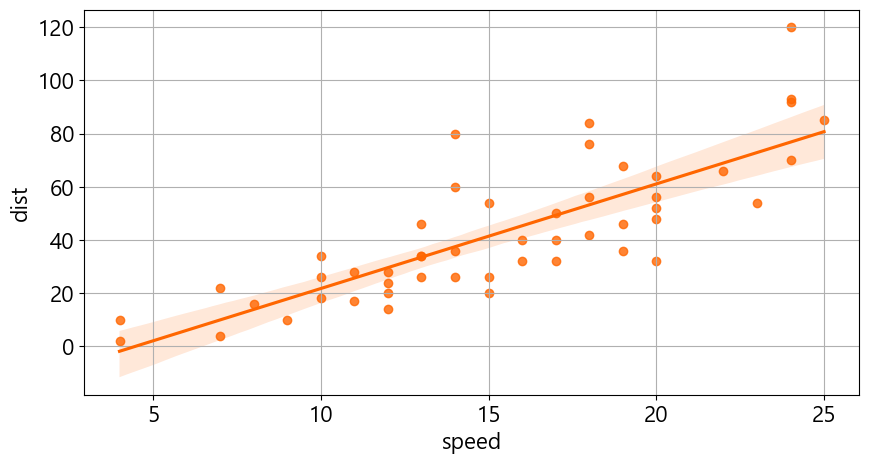

In [5]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
sb.regplot(data=origin, x='speed', y='dist', color='#ff6600')
plt.grid()

plt.show()
plt.close()

> 추세선을 보고 선형을 띈다면 다항식 X = degree 결정 <br> 곡선보다는 선형 분포에 더 가까우므로 단순선형회귀모델을 적용하기로 함

## #05. 데이터 분할

### 1. 랜덤시드 고정

In [6]:
np.random.seed(777)

### 2. 훈련데이터(독립변수)와 레이블(종속변수) 구분하기

In [7]:
x = origin.drop(['dist'], axis=1)
y = origin[['dist']]
print("훈련데이터크기:", x.shape, '/레이블크기:', y.shape)

훈련데이터크기: (50, 1) /레이블크기: (50, 1)


### (추가) 데이터 정규화(표준화) 수행

#### 독립변수 표준화

In [8]:
x_scaler = MinMaxScaler()
x_scale = x_scaler.fit_transform(x)
x_scale

array([[0.        ],
       [0.        ],
       [0.14285714],
       [0.14285714],
       [0.19047619],
       [0.23809524],
       [0.28571429],
       [0.28571429],
       [0.28571429],
       [0.33333333],
       [0.33333333],
       [0.38095238],
       [0.38095238],
       [0.38095238],
       [0.38095238],
       [0.42857143],
       [0.42857143],
       [0.42857143],
       [0.42857143],
       [0.47619048],
       [0.47619048],
       [0.47619048],
       [0.47619048],
       [0.52380952],
       [0.52380952],
       [0.52380952],
       [0.57142857],
       [0.57142857],
       [0.61904762],
       [0.61904762],
       [0.61904762],
       [0.66666667],
       [0.66666667],
       [0.66666667],
       [0.66666667],
       [0.71428571],
       [0.71428571],
       [0.71428571],
       [0.76190476],
       [0.76190476],
       [0.76190476],
       [0.76190476],
       [0.76190476],
       [0.85714286],
       [0.9047619 ],
       [0.95238095],
       [0.95238095],
       [0.952

#### 종속변수 표준화

In [9]:
y_scaler = MinMaxScaler()
y_scale = y_scaler.fit_transform(y)
y_scale

array([[0.        ],
       [0.06779661],
       [0.01694915],
       [0.16949153],
       [0.11864407],
       [0.06779661],
       [0.13559322],
       [0.20338983],
       [0.27118644],
       [0.12711864],
       [0.22033898],
       [0.10169492],
       [0.15254237],
       [0.18644068],
       [0.22033898],
       [0.20338983],
       [0.27118644],
       [0.27118644],
       [0.37288136],
       [0.20338983],
       [0.28813559],
       [0.49152542],
       [0.66101695],
       [0.15254237],
       [0.20338983],
       [0.44067797],
       [0.25423729],
       [0.3220339 ],
       [0.25423729],
       [0.3220339 ],
       [0.40677966],
       [0.33898305],
       [0.45762712],
       [0.62711864],
       [0.69491525],
       [0.28813559],
       [0.37288136],
       [0.55932203],
       [0.25423729],
       [0.38983051],
       [0.42372881],
       [0.45762712],
       [0.52542373],
       [0.54237288],
       [0.44067797],
       [0.57627119],
       [0.76271186],
       [0.771

### 3. 훈련데이터와 검증데이터 분할

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_scale,y_scale,test_size=0.3, random_state=777)
print("훈련용 데이터셋 크기 : %d, 검증용 데이터셋 크기: %d" % (len(x_train), len(x_test)))

훈련용 데이터셋 크기 : 35, 검증용 데이터셋 크기: 15


## #06. 모델 개발

### 1. 모델정의

In [11]:
#객체 만들기
model = Sequential() 

#1 차원의 데이터를 입력받고, 32개의 출력을 가지는 "첫번째 Dense층"
# input_shape = 독립변수의 갯수
model.add(Dense(32, activation='relu', input_shape=(1, )))
# 하나의 값을 출력
# -> 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
# -> linear는 기본값이므로 생략 가능함
# "마지막 Dense층"만 제시 ; model.add(Dense(1, activation='linear')) 하면 중간층은 알아서 해줌
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                64        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 2. (수정) 학습하기

In [13]:
#result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test))

# 파일이 저장될 경로(폴더) 지정(한글, 공백, 점(.)이 포함되어 있을 경우 에러 발생함)
checkpoint_path = os.path.join("C;\\tensorflow_checkpoint\\mode107-cp-{epoch:04d}-ckpt")

result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath = checkpoint_path, monitor = 'val_loss', verbose=1, save_best_only = True)
])

# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/500
1/2 [==============>...............] - ETA: 0s - loss: 0.1562 - mae: 0.3298
Epoch 1: val_loss improved from inf to 0.09093, saving model to C;\tensorflow_checkpoint\mode107-cp-0001-ckpt


FailedPreconditionError: C;\tensorflow_checkpoint is not a directory

## #07. 학습결과 평가

### 1. 학습결과 시각화

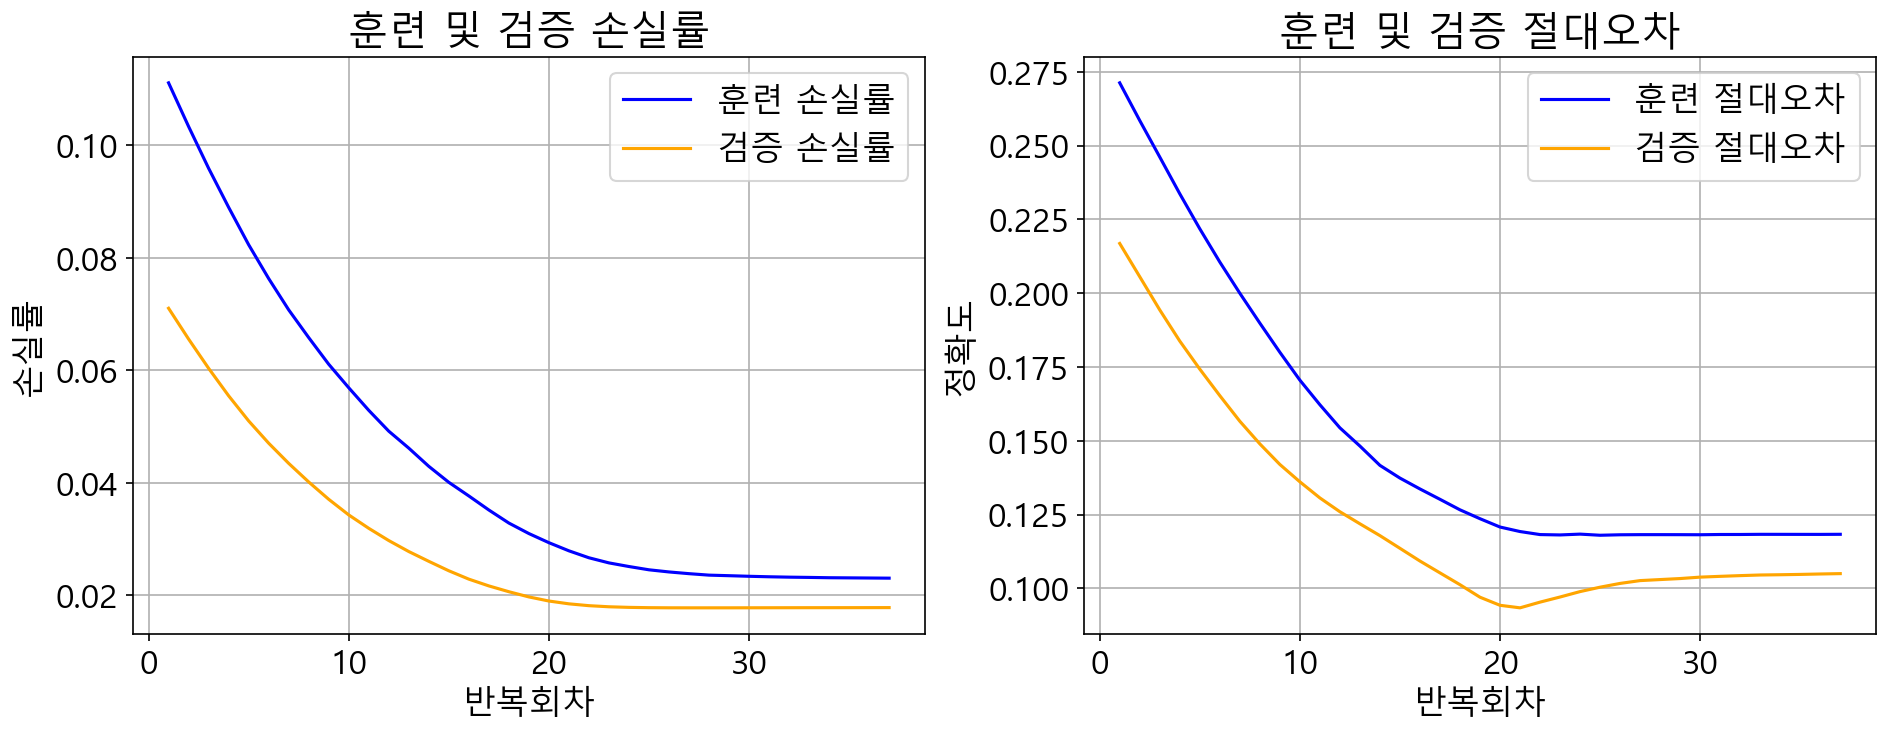

In [ ]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# -----------------------------------------
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
#-------------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
#-------------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color='blue', label='훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color='orange', label='검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()


> ephocs를 500으로 지정했지만 일찍 학습을 멈춘 것을 확인할 수 있다. 즉, 학습을 조기 종료함으로서 학습 성능을 향상시켰다고 할 수 있다.

### 2. 모델 성능 평가

In [ ]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 8ms/step - loss: 0.0230 - mae: 0.1183
최종 훈련 손실률: 0.023048, 최종 훈련 절대오차: 0.118311
1/1 [==============================] - 0s 32ms/step - loss: 0.0178 - mae: 0.1050
최종 검증 손실률: 0.017839, 최종 검증 절대오차: 0.104980


## #08. 학습결과 적용

### 1. 테스트 데이터에 대한 예측 결과 산정

In [ ]:
results = model.predict(x_test)
print(results)

1/1 [==============================] - 0s 71ms/step
[[0.4950133 ]
 [0.3022076 ]
 [0.2821999 ]
 [0.26219222]
 [0.41919953]
 [0.3222153 ]
 [0.3222153 ]
 [0.40024605]
 [0.2821999 ]
 [0.41919953]
 [0.3222153 ]
 [0.43815294]
 [0.1815202 ]
 [0.3022076 ]
 [0.10694815]]


### 2. 결과 데이터 셋 구성

In [ ]:
kdf = DataFrame({
    '검증데이터': x_test.flatten(),
    '실제값': y_test.flatten(), 
    '예측값': results.flatten()
})

# 예측오차 = 잔차
kdf['예측오차'] = kdf['실제값'] - kdf['예측값']

kdf

,검증데이터,실제값,예측값,예측오차
0,0.904762,0.440678,0.495013,-0.054335
1,0.428571,0.271186,0.302208,-0.031021
2,0.380952,0.101695,0.282200,-0.180505
3,0.333333,0.127119,0.262192,-0.135074
4,0.714286,0.372881,0.419200,-0.046318
5,0.476190,0.491525,0.322215,0.169310
6,0.476190,0.661017,0.322215,0.338802
7,0.666667,0.338983,0.400246,-0.061263
8,0.380952,0.152542,0.282200,-0.129658
9,0.714286,0.559322,0.419200,0.140123


### 3. 실제 결과값과 머신러닝에 의한 예측값 비교

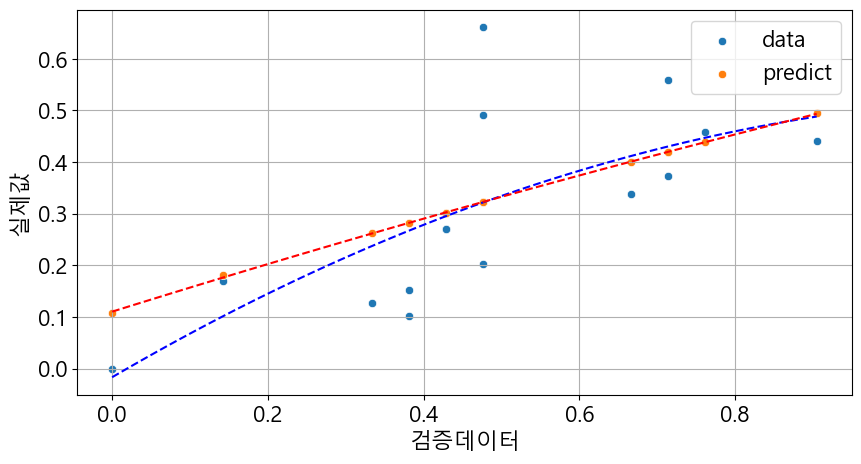

In [ ]:
helper.regplot(x_left=kdf['검증데이터'], y_left=kdf['실제값'], y_left_pred=kdf['예측값'])

### 4. 임의의 값에 대한 머신러닝 예측 결과

In [ ]:
# 속도가 50일때의 제동거리를 예측해보자
my_speed = 50

In [ ]:
# 독립변수 표준화에 사용한 객체를 활용
my_speed_scale = x_scaler.transform([[my_speed]])
my_speed_scale

c:\Users\hanjieun_2\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[2.19047619]])

In [ ]:
results = model.predict(my_speed_scale)
results

1/1 [==============================] - 0s 24ms/step


array([[1.0067561]], dtype=float32)

In [ ]:
# 예측 결과는 표준화된 값으로 나오기 때문에 원래의 단위로 되돌리기 위해 역변환
y_scaler.inverse_transform(results)

array([[120.79722]], dtype=float32)

fit은 규칙을 찾는 것
transform은 수행하는 것.